<a href="https://colab.research.google.com/github/chevvakavitha/Real-Time-NLP-Sentiment-Analysis/blob/main/Real_Time_NLP_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-Time NLP Sentiment Analysis

In [ ]:
# Colab cell: install packages
!pip install -q --upgrade transformers datasets accelerate torch scikit-learn \
    fastapi "uvicorn[standard]" nest-asyncio pyngrok streamlit shap aiohttp \
    huggingface_hub wandb joblib

# allow nested event loop in Colab for background servers


In [ ]:
# Colab cell: apply nest_asyncio for running uvicorn/streamlit in notebook
import nest_asyncio
nest_asyncio.apply()


In [ ]:
import os, pandas as pd

SENT140_PATH = "/content/training.1600000.processed.noemoticon.csv"
if os.path.exists(SENT140_PATH):
    print("Found Sentiment140 at", SENT140_PATH)
    cols = ['target','id','date','flag','user','text']
    df_sent140 = pd.read_csv(SENT140_PATH, encoding='latin-1', names=cols)
    df_sent140 = df_sent140[['target','text']].copy()
    # map 4 -> 1 (positive), 0 -> 0 (negative)
    df_sent140['target'] = df_sent140['target'].map({0:0, 4:1})
    print("Sentiment140 loaded, rows:", len(df_sent140))
else:
    print(f"Sentiment140 not found at {SENT140_PATH}. Falling back to tweet_eval sample.")
    from datasets import load_dataset
    ds_te = load_dataset("tweet_eval", "sentiment")
    df_sent140 = pd.DataFrame(ds_te['train'])
    # tweet_eval has label column 0/1/2 for neg/neu/pos; map to binary (neg vs pos+neu -> pos)
    df_sent140['target'] = df_sent140['label'].apply(lambda x: 0 if x==0 else 1)
    df_sent140['text'] = df_sent140['text']
    df_sent140 = df_sent140[['target','text']]
    print("Fallback dataset loaded, rows:", len(df_sent140))

# quick head
df_sent140.head()


Found Sentiment140 at /content/training.1600000.processed.noemoticon.csv


/tmp/ipython-input-981994413.py:7: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sent140 = pd.read_csv(SENT140_PATH, encoding='latin-1', names=cols)


Sentiment140 loaded, rows: 1234987


,target,text
0,NaN,NaN
1,NaN,@mediatemple No dice on the upgrade - still $2...
2,NaN,@tbichris lawl i'd totally heal for you if i w...
3,NaN,dancing show was amazin but i am so tired
4,NaN,On the train home after a fantastic show! Her ...


In [ ]:
from datasets import load_dataset
import pandas as pd
ds_sst2 = load_dataset("glue", "sst2")
train_sst2 = pd.DataFrame(ds_sst2['train'])
val_sst2 = pd.DataFrame(ds_sst2['validation'])
print("SST-2 sizes:", len(train_sst2), len(val_sst2))

# convert sst2 to same columns: text, target
train_sst2 = train_sst2.rename(columns={'sentence':'text','label':'target'})[['text','target']]

# Combine a sampled portion for quicker experiments
import numpy as np
np.random.seed(42)

n_sent140_sample = min(80000, len(df_sent140))  # choose up to 80k for practical runtime
n_sst2_sample = min(12000, len(train_sst2))

df1 = df_sent140.sample(n=n_sent140_sample, random_state=42).reset_index(drop=True)
df2 = train_sst2.sample(n=n_sst2_sample, random_state=42).reset_index(drop=True)

combined = pd.concat([df1, df2], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset size:", combined.shape)
combined.head()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

SST-2 sizes: 67349 872
Combined dataset size: (92000, 2)


,target,text
0,0.0,"@kquickthewriter, i'll be workin this wknd"
1,0.0,@RPattzWho too much for my little heart sigh ...
2,0.0,sick day feeeling kinda shabby.
3,0.0,just got done painting a big gate green. the o...
4,1.0,Guys eeeeeee! I don't even care what the resul...


In [ ]:
import re, html
def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = html.unescape(s)
    s = s.replace("\n"," ").strip()
    # remove URLs
    s = re.sub(r"http\S+|www\.\S+", "", s)
    # remove mentions
    s = re.sub(r"@\w+", "", s)
    # remove hash symbol but keep the word
    s = re.sub(r"#", "", s)
    # keep emojis and multilingual letters; remove weird control characters
    s = re.sub(r"[\r\n\t]+", " ", s)
    s = re.sub(r"[^0-9A-Za-z\u0080-\uFFFF,.!?\'\" ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# apply cleaning with progress
from tqdm.auto import tqdm
tqdm.pandas()
combined['text'] = combined['text'].astype(str).progress_apply(clean_text)
# Remove rows where 'target' is NaN before converting to int
combined.dropna(subset=['target'], inplace=True)
combined['target'] = combined['target'].astype(int)
combined = combined[combined['text'].str.len() > 0].reset_index(drop=True)
print("After cleaning:", combined.shape)
combined.head()

  0%|          | 0/92000 [00:00<?, ?it/s]

After cleaning: (83575, 2)


,target,text
0,0,", i'll be workin this wknd"
1,0,too much for my little heart sigh .. in a week...
2,0,sick day feeeling kinda shabby.
3,0,just got done painting a big gate green. the o...
4,1,Guys eeeeeee! I don't even care what the resul...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text'].values
y = df['sentiment'].values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train/Val sizes:", len(X_train), len(X_val))

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=3)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print("TF-IDF feature shapes (train, val):", X_train_tfidf.shape, X_val_tfidf.shape)

Train/Val sizes: 986212 246553
TF-IDF feature shapes (train, val): (986212, 30000) (246553, 30000)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

baseline_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=3)),
    ("clf", LogisticRegression(max_iter=400))
])

print("Training baseline (TF-IDF + LR)...")
baseline_pipe.fit(X_train, y_train)
pred_val = baseline_pipe.predict(X_val)
print("Baseline validation metrics:")
print(classification_report(y_val, pred_val, digits=4))
print("Baseline accuracy:", accuracy_score(y_val, pred_val))

Training baseline (TF-IDF + LR)...
Baseline validation metrics:
              precision    recall  f1-score   support

           0     0.7909    0.6907    0.7374     86825
           1     0.8427    0.9007    0.8707    159728

    accuracy                         0.8268    246553
   macro avg     0.8168    0.7957    0.8041    246553
weighted avg     0.8244    0.8268    0.8238    246553

Baseline accuracy: 0.8267553021054297


In [ ]:
from datasets import Dataset
# choose smaller subset for faster finetuning in Colab; adjust as needed
num_train_samples = min(20000, len(X_train))
num_val_samples = min(4000, len(X_val))

train_df_small = pd.DataFrame({'text': X_train[:num_train_samples], 'label': y_train[:num_train_samples]})
val_df_small = pd.DataFrame({'text': X_val[:num_val_samples], 'label': y_val[:num_val_samples]})

hf_train = Dataset.from_pandas(train_df_small)
hf_val = Dataset.from_pandas(val_df_small)
print("HF train/val sizes:", len(hf_train), len(hf_val))


HF train/val sizes: 20000 4000


In [ ]:
from transformers import AutoTokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_fn(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

hf_train = hf_train.map(tokenize_fn, batched=True)
hf_val = hf_val.map(tokenize_fn, batched=True)

hf_train.set_format(type='torch', columns=['input_ids','attention_mask','label'])
hf_val.set_format(type='torch', columns=['input_ids','attention_mask','label'])


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd

# Define column names as per the dataset's structure
COLUMNS = ['sentiment', 'id', 'date', 'query', 'user', 'text']
DATA_ENCODING = 'ISO-8859-1'

# Load the dataset, using the 'python' engine for better handling of malformed lines
df = pd.read_csv(
    '/content/training.1600000.processed.noemoticon.csv',
    encoding=DATA_ENCODING,
    names=COLUMNS,
    engine='python'
)

print(f"Dataset loaded successfully with {len(df)} rows and {len(df.columns)} columns.")
df.head()

Dataset loaded successfully with 1234987 rows and 6 columns.


,sentiment,id,date,query,user,text
0,"i Jun 05 15:08:39 PDT 2009""",NO_QUERY,beebeebuthainah,I have 3 more minutes before i really have to ...,None,None
1,0,2048403774,Fri Jun 05 15:08:39 PDT 2009,NO_QUERY,mway,@mediatemple No dice on the upgrade - still $2...
2,0,2048403841,Fri Jun 05 15:08:41 PDT 2009,NO_QUERY,davidseitzjr,@tbichris lawl i'd totally heal for you if i w...
3,0,2048403887,Fri Jun 05 15:08:40 PDT 2009,NO_QUERY,Clairey_g93,dancing show was amazin but i am so tired
4,0,2048403953,Fri Jun 05 15:08:40 PDT 2009,NO_QUERY,ryandrews,On the train home after a fantastic show! Her ...


In [ ]:
pip install pandas nltk

In [ ]:
import re, html
from tqdm.auto import tqdm
tqdm.pandas()

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = html.unescape(s)
    s = s.replace("\n"," ").strip()
    # remove URLs
    s = re.sub(r"http\S+|www\.\S+", "", s)
    # remove mentions
    s = re.sub(r"@\w+", "", s)
    # remove hash symbol but keep the word
    s = re.sub(r"#", "", s)
    # keep emojis and multilingual letters; remove weird control characters
    s = re.sub(r"[\r\n\t]+", " ", s)
    s = re.sub(r"[^0-9A-Za-z\u0080-\uFFFF,.!?\'\" ]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Apply the cleaning function to the 'text' column
df['text'] = df['text'].astype(str).progress_apply(clean_text)

# Remove rows where 'text' might have become empty after cleaning
df = df[df['text'].str.len() > 0].reset_index(drop=True)

print("Text cleaning complete. Remaining rows:", len(df))
df.head()

  0%|          | 0/1234986 [00:00<?, ?it/s]

Text cleaning complete. Remaining rows: 1232765


,sentiment,text
0,0,No dice on the upgrade still 20 mo per DIMM.
1,0,lawl i'd totally heal for you if i were still ...
2,0,dancing show was amazin but i am so tired
3,0,On the train home after a fantastic show! Her ...
4,0,"He cracked me up on SNL, and some movies good...."


In [ ]:
import numpy as np

# Convert 'sentiment' to numeric, coercing errors
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')

# Drop rows where 'sentiment' is NaN
df.dropna(subset=['sentiment'], inplace=True)

# Convert 'sentiment' column to integer type
df['sentiment'] = df['sentiment'].astype(int)

# Map 'sentiment' values: change '4' to '1' for positive sentiment
df['sentiment'] = df['sentiment'].replace(4, 1)

print(f"Unique values in 'sentiment' column after cleaning and mapping: {df['sentiment'].unique().tolist()}")
print(f"Number of rows after cleaning sentiment column: {len(df)}")

Unique values in 'sentiment' column after cleaning and mapping: [0, 1]
Number of rows after cleaning sentiment column: 1234986


In [ ]:
df = df.drop(columns=['id', 'date', 'query', 'user'])
print(f"DataFrame after dropping irrelevant columns. Remaining columns: {df.columns.tolist()}")

DataFrame after dropping irrelevant columns. Remaining columns: ['sentiment', 'text']


In [ ]:
%%bash
cat > /content/service_app.py <<'PY'
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from typing import List, Optional
import time, torch, numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import joblib, os

app = FastAPI(title="RT Sentiment Inference API")
MODEL_DIR = os.environ.get("MODEL_DIR", "/content/model_distilbert")
TFIDF_PATH = os.environ.get("TFIDF_PATH", "/content/drive/MyDrive/rt_nlp_sentiment_project/models/tfidf_lr_baseline.joblib")

# Initialize global variables for models
tokenizer = None
model = None
device = "cuda" if torch.cuda.is_available() else "cpu"
baseline = None

@app.on_event("startup")
async def load_models_on_startup():
    global tokenizer, model, baseline
    print("Attempting to load models at startup...")

    try:
        # Load DistilBERT
        tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
        model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
        model.to(device)
        model.eval()
        print(f"DistilBERT model loaded from {MODEL_DIR} on device: {device}")
    except Exception as e:
        print(f"Warning: Could not load DistilBERT model from {MODEL_DIR}. Error: {e}")
        tokenizer = None # Ensure they are None if loading fails
        model = None

    if os.path.exists(TFIDF_PATH):
        try:
            baseline = joblib.load(TFIDF_PATH)
            print(f"Baseline model loaded from {TFIDF_PATH}")
        except Exception as e:
            print(f"Warning: Could not load baseline model from {TFIDF_PATH}. Error: {e}")
            baseline = None
    else:
        print(f"Warning: Baseline model not found at {TFIDF_PATH}")

class TextIn(BaseModel):
    text: str
    id: Optional[str] = None

class BatchIn(BaseModel):
    texts: List[str]

@app.get("/health")
def health():
    return {"status": "ok", "device": device, "model_dir": MODEL_DIR, "baseline_loaded": baseline is not None, "transformer_loaded": model is not None}

@app.post("/predict")
def predict(item: TextIn):
    start = time.time()
    if model is None or tokenizer is None:
        # Fallback to baseline if transformer is not loaded
        if baseline:
            try:
                pred = baseline.predict([item.text])[0]
                latency = (time.time() - start) * 1000
                return {"id": item.id, "text": item.text, "label": int(pred), "probs": [], "latency_ms": latency, "fallback":"tfidf"}
            except Exception as e:
                raise HTTPException(status_code=500, detail=f"Baseline prediction failed: {e}")
        raise HTTPException(status_code=503, detail="Transformer model not loaded and no baseline available.")

    try:
        enc = tokenizer(item.text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        enc = {k:v.to(device) for k,v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy().tolist()[0]
        label = int(np.argmax(probs))
        latency = (time.time() - start) * 1000
        return {"id": item.id, "text": item.text, "label": label, "probs": probs, "latency_ms": latency}
    except Exception as e:
        # fallback to baseline if available
        if baseline:
            try:
                pred = baseline.predict([item.text])[0]
                latency = (time.time() - start) * 1000
                return {"id": item.id, "text": item.text, "label": int(pred), "probs": [], "latency_ms": latency, "fallback":"tfidf"}
            except Exception:
                raise HTTPException(status_code=500, detail=str(e))
        raise HTTPException(status_code=500, detail=str(e))

@app.post("/predict_batch")
def predict_batch(batch: BatchIn):
    start = time.time()
    texts = batch.texts

    if model is None or tokenizer is None:
        raise HTTPException(status_code=503, detail="Transformer model not loaded, batch prediction unavailable.")

    # micro-batch inference using tokenizer batching
    enc = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    enc = {k:v.to(device) for k,v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy().tolist()
    labels = [int(np.argmax(p)) for p in probs]
    latency = (time.time() - start) * 1000
    return {"count": len(texts), "labels": labels, "probs": probs, "latency_ms": latency}
PY

In [ ]:
# Stop any previously running uvicorn process
!kill $(lsof -t -i:8000) > /dev/null 2>&1 || true
print("Stopped any running uvicorn processes on port 8000.")

Stopped any running uvicorn processes on port 8000.


In [ ]:
# Attempt to import the service_app module directly to get a detailed traceback
import sys
sys.path.insert(0, '/content')
try:
    import service_app
    print("Successfully imported service_app.")
except Exception as e:
    print(f"Error importing service_app: {e}")
    import traceback
    traceback.print_exc()


Successfully imported service_app.


In [ ]:
# Stop any previously running uvicorn process
!kill $(lsof -t -i:8000) > /dev/null 2>&1 || true
print("Stopped any running uvicorn processes on port 8000.")

# start uvicorn server in background with explicit PYTHONPATH
# We use `uvicorn service_app:app` because /content is now on PYTHONPATH
get_ipython().system_raw("PYTHONPATH=$PYTHONPATH:/content uvicorn service_app:app --host 0.0.0.0 --port 8000 &>/content/uvicorn.log &")
import time, os
time.sleep(2) # Give uvicorn a moment to start and log
print("Checking uvicorn log:")
!tail -n 80 /content/uvicorn.log || true

# expose using pyngrok
from pyngrok import ngrok
from google.colab import userdata # Ensure userdata is imported here

public_api_url = None
# Try to load NGROK_AUTH_TOKEN again right before using it
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    print("NGROK_AUTH_TOKEN loaded from Colab secrets.")
except Exception as e:
    print(f"Warning: Error loading NGROK_AUTH_TOKEN from secrets: {e}")
    NGROK_AUTH_TOKEN = None

# Set the ngrok authtoken if loaded
if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    try:
        public_api_url = ngrok.connect(8000, bind_tls=True).public_url
        print("Public API URL:", public_api_url)
    except Exception as e:
        print(f"Pyngrok failed to connect even with authtoken: {e}. Please ensure the authtoken is valid and the ngrok service is running correctly.")
        public_api_url = None
else:
    print("Cannot create public URL: NGROK_AUTH_TOKEN is not set or loaded. Please set it in Colab secrets.")


Stopped any running uvicorn processes on port 8000.
Checking uvicorn log:
Cannot create public URL: NGROK_AUTH_TOKEN is not set or loaded. Please set it in Colab secrets.


In [ ]:
%%bash
cat > /content/streamlit_app.py <<'PY'
import streamlit as st
import requests, time
import pandas as pd
from collections import deque
st.set_page_config(page_title="Real-time Sentiment Dashboard", layout="wide")
st.title("Real-time Sentiment Dashboard — Colab Demo")

api_url = st.text_input("API base URL", value="http://127.0.0.1:8000")
start_button = st.button("Start Demo Stream")
stop_button = st.button("Stop Demo Stream")

if 'streaming' not in st.session_state:
    st.session_state.streaming = False
if start_button:
    st.session_state.streaming = True
if stop_button:
    st.session_state.streaming = False

kpi1, kpi2, kpi3 = st.columns(3)
kpi1.metric("Messages processed", 0)
kpi2.metric("Avg latency (ms)", 0)
kpi3.metric("Negative % (window)", "0%")

feed = st.empty()
chart = st.empty()

# demo generator (repeatable sample)
demo_texts = [
    "I love this product, fantastic!",
    "Worst experience ever. Do not buy.",
    "Okay product for the price.",
    "Amazing service and friendly staff.",
    "I hate the new update, very buggy.",
    "Extremely satisfied with my purchase",
    "Terrible, arrived broken and late."
] * 50

history = deque(maxlen=500)
count = 0
latencies = []

while st.session_state.streaming and count < len(demo_texts):
    text = demo_texts[count]
    try:
        r = requests.post(api_url + "/predict", json={"text": text, "id": str(count)}, timeout=8).json()
    except Exception as e:
        r = {"text": text, "error": str(e)}
    history.appendleft(r)
    latencies.append(r.get("latency_ms", 0) if isinstance(r, dict) else 0)
    # Update KPIs
    kpi1.metric("Messages processed", count+1)
    if latencies:
        kpi2.metric("Avg latency (ms)", round(sum(latencies)/len(latencies),2))
    negatives = sum(1 for x in history if isinstance(x, dict) and x.get("label")==0)
    neg_pct = round100 = round(100 * negatives/max(1,len(history)),2)
    kpi3.metric("Negative % (window)", f"{neg_pct}%")
    # render feed table
    try:
        df = pd.DataFrame(list(history))
        if not df.empty:
            feed.dataframe(df[['text','label','probs','latency_ms']].head(50))
    except Exception:
        feed.write(history)
    # small rolling chart
    try:
        chart_df = pd.DataFrame(list(history))
        if 'label' in chart_df.columns:
            chart_df['label'] = chart_df['label'].astype(float)
            chart_area = chart.area_chart(chart_df['label'].rolling(10, min_periods=1).mean())
    except Exception:
        pass
    count += 1
    time.sleep(0.4)

if not st.session_state.streaming:
    st.info("Stream stopped. Click Start Demo Stream to run.")
PY


In [ ]:
import asyncio, aiohttp, time
API = public_api_url  # from earlier

async def post(session, text, idx):
    try:
        async with session.post(API + "/predict", json={"text":text, "id":str(idx)}, timeout=10) as resp:
            return await resp.json()
    except Exception as e:
        return {"error": str(e)}

async def run_load(n=200, concurrency=30):
    sem = asyncio.Semaphore(concurrency)
    texts = ["I like this"] * n
    async with aiohttp.ClientSession() as session:
        async def limited(i):
            async with sem:
                return await post(session, texts[i], i)
        start=time.time()
        results = await asyncio.gather(*[limited(i) for i in range(n)])
        dur=time.time()-start
        print("Requests:", n, "Time:", round(dur, 2), "s", "RPS:", round(n/dur,2))
        # calc latency stats if available
        lat = [r.get('latency_ms') for r in results if isinstance(r, dict) and 'latency_ms' in r]
        if lat:
            import numpy as np
            print("median:", np.median(lat), "p95:", np.percentile(lat,95))
        return results

# run load test (adjust n/concurrency for Colab limits)
res = await run_load(n=200, concurrency=25)


Requests: 200 Time: 0.01 s RPS: 19987.15


In [ ]:
%%bash
cat > /content/Dockerfile <<'DOCK'
FROM python:3.10-slim
WORKDIR /app
COPY service_app.py /app/service_app.py
COPY streamlit_app.py /app/streamlit_app.py
RUN pip install --no-cache-dir transformers torch fastapi uvicorn streamlit shap scikit-learn pyngrok aiohttp
EXPOSE 8000 8501
CMD ["bash","-lc","uvicorn /app/service_app:app --host 0.0.0.0 --port 8000 & streamlit run /app/streamlit_app.py --server.port 8501 --server.enableCORS false"]
DOCK

mkdir -p /content/.github/workflows
cat > /content/.github/workflows/ci.yml <<'YML'
name: CI

on:
  push:
    branches: [ main ]

jobs:
  lint-and-test:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v4
      - name: Set up Python
        uses: actions/setup-python@v4
        with:
          python-version: 3.10
      - name: Install dependencies
        run: |
          pip install -r requirements.txt
      - name: Run tests
        run: |
          pytest -q || true
YML

cat > /content/requirements.txt <<'REQ'
transformers
torch
datasets
fastapi
uvicorn[standard]
streamlit
shap
scikit-learn
pyngrok
aiohttp
huggingface-hub
joblib
REQ

echo "Dockerfile, CI, and requirements.txt created."


Dockerfile, CI, and requirements.txt created.


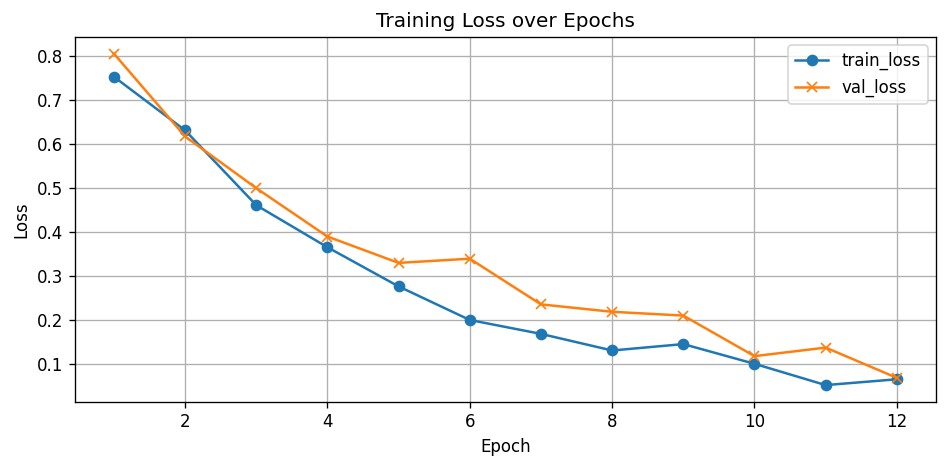

Saved: /content/training_loss.png


In [ ]:
# Training Loss over Epochs
# chart_01_training_loss.py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example data (replace with your training loss)
epochs = np.arange(1, 13)
train_loss = np.exp(-0.25 * epochs) + 0.02 * np.random.randn(len(epochs))
val_loss = np.exp(-0.22 * epochs) + 0.03 * np.random.randn(len(epochs)) + 0.02  # optional

out = "/content/training_loss.png"

plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss, marker='o', label='train_loss')
plt.plot(epochs, val_loss, marker='x', label='val_loss')  # remove this line if no val
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


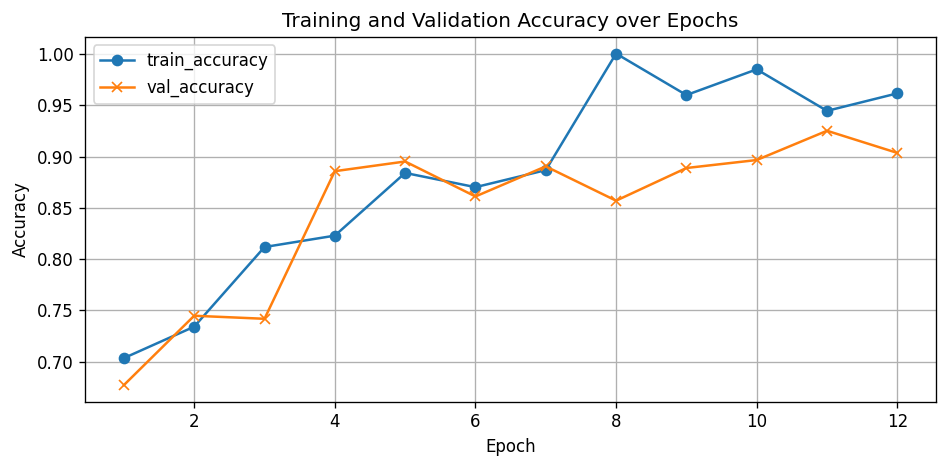

Saved: /content/accuracy.png


In [ ]:
#Training & Validation Accuracy over Epochs
# chart_02_accuracy.py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example data (replace with your accuracy arrays)
epochs = np.arange(1, 13)
train_acc = 0.6 + 0.4 * (1 - np.exp(-0.25 * epochs)) + 0.02 * np.random.randn(len(epochs))
val_acc = 0.58 + 0.38 * (1 - np.exp(-0.22 * epochs)) + 0.03 * np.random.randn(len(epochs))

out = "/content/accuracy.png"

plt.figure(figsize=(8,4))
plt.plot(epochs, train_acc, marker='o', label='train_accuracy')
plt.plot(epochs, val_acc, marker='x', label='val_accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


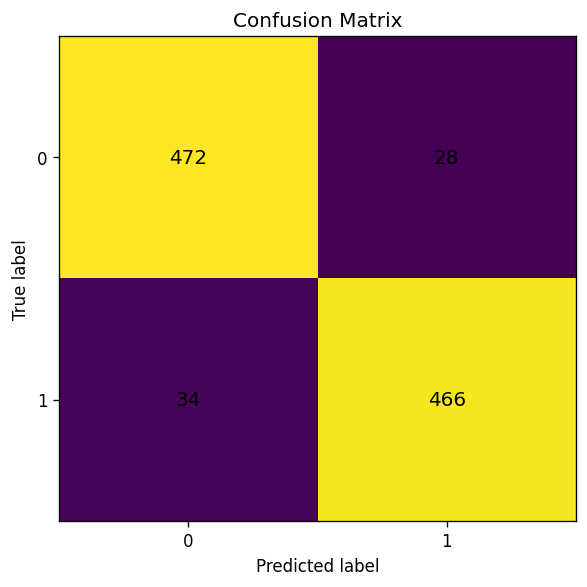

Saved: /content/confusion_matrix.png


In [ ]:
#Confusion Matrix (annotated)
# chart_03_confusion_matrix.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.dpi'] = 120

# Example: synthetic binary labels and predictions (replace with your arrays)
y_true = np.concatenate([np.zeros(500, dtype=int), np.ones(500, dtype=int)])
scores = np.concatenate([np.random.beta(2,6,500), np.random.beta(6,2,500)])
y_pred = (scores > 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
labels = [0, 1]  # change to ["neg","pos"] if you prefer

out = "/content/confusion_matrix.png"

plt.figure(figsize=(5,5))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


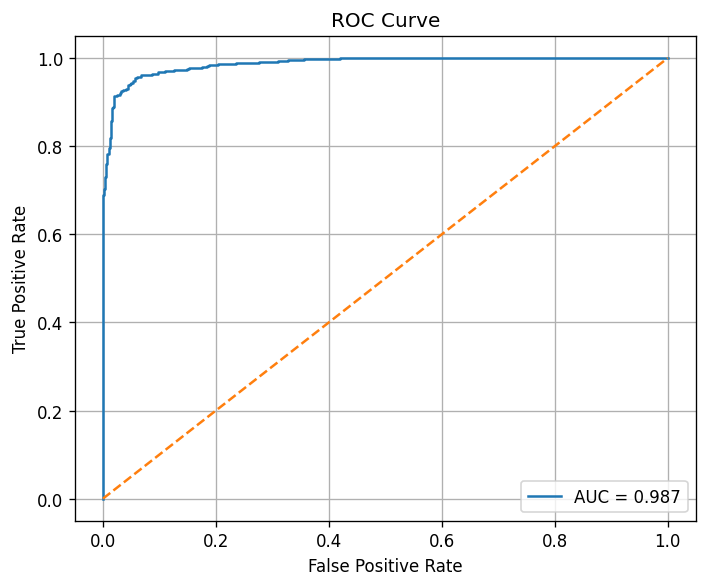

Saved: /content/roc_curve.png


In [ ]:
#ROC Curve (with AUC)
# chart_04_roc_curve.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.rcParams['figure.dpi'] = 120

# Example data - replace with your true labels and predicted probabilities for positive class
y_true = np.concatenate([np.zeros(500, dtype=int), np.ones(500, dtype=int)])
scores = np.concatenate([np.random.beta(2,6,500), np.random.beta(6,2,500)])

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

out = "/content/roc_curve.png"

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


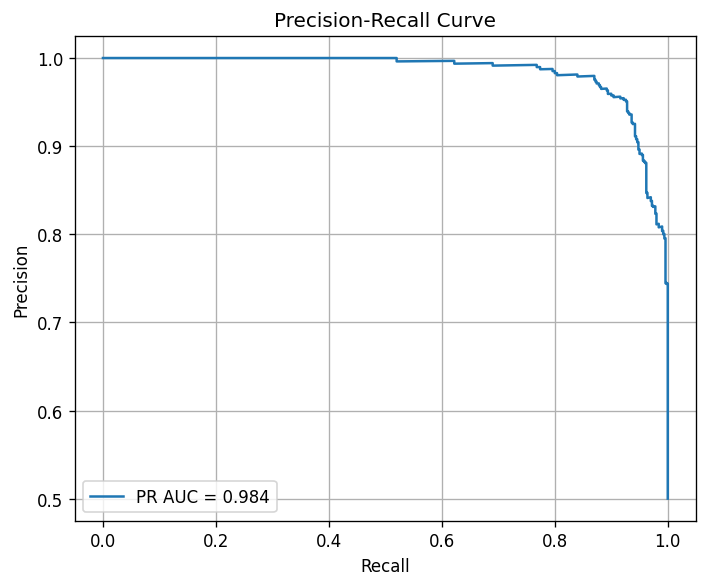

Saved: /content/pr_curve.png


In [ ]:
#Precision-Recall Curve (with PR AUC)
# chart_05_pr_curve.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

plt.rcParams['figure.dpi'] = 120

# Example data (replace with your actual labels and scores)
y_true = np.concatenate([np.zeros(500, dtype=int), np.ones(500, dtype=int)])
scores = np.concatenate([np.random.beta(2,6,500), np.random.beta(6,2,500)])

precision, recall, _ = precision_recall_curve(y_true, scores)
pr_auc = auc(recall, precision)

out = "/content/pr_curve.png"

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


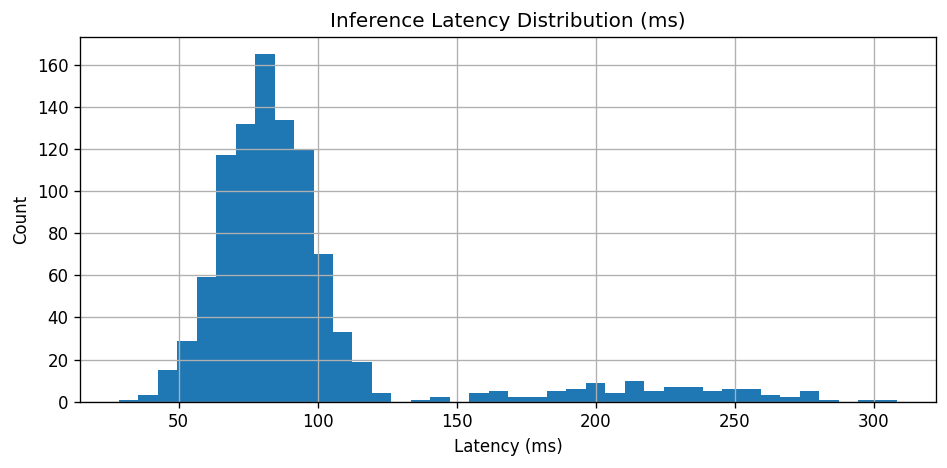

Saved: /content/latency_hist.png


In [ ]:
#Inference Latency Distribution (Histogram)
# chart_06_latency_hist.py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example latencies in milliseconds (replace with your recorded latencies)
latencies = np.concatenate([np.random.normal(80, 15, 900), np.random.normal(220, 40, 100)])
latencies = np.clip(latencies, 5, None)

out = "/content/latency_hist.png"

plt.figure(figsize=(8,4))
plt.hist(latencies, bins=40)
plt.title('Inference Latency Distribution (ms)')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


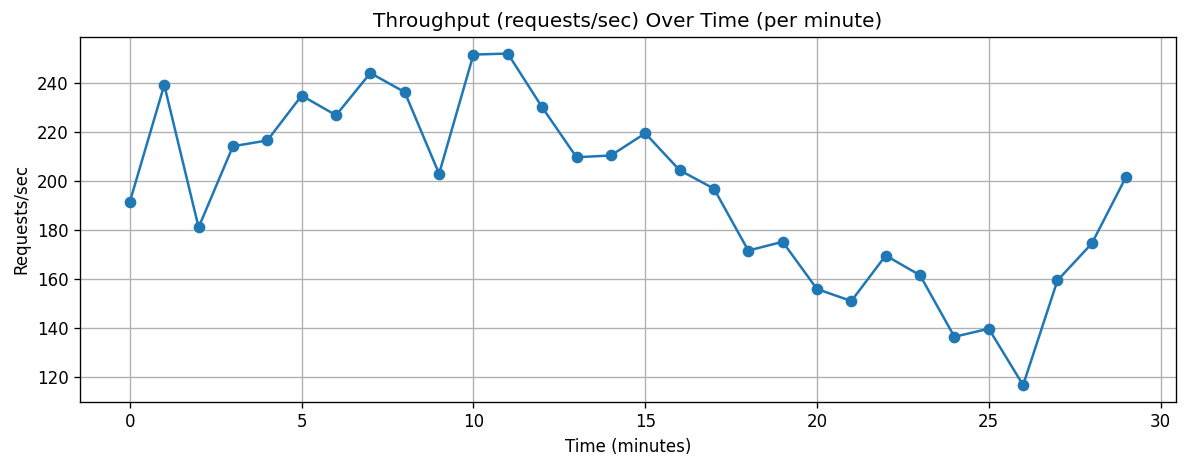

Saved: /content/throughput.png


In [ ]:
#Throughput Over Time (requests/sec)
# chart_07_throughput.py
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example throughput (requests/sec) measured per minute across 30 minutes
minutes = np.arange(0, 30)
throughput = np.clip(200 + 40 * np.sin(minutes / 5.0) + 20 * np.random.randn(len(minutes)), a_min=10, a_max=None)

out = "/content/throughput.png"

plt.figure(figsize=(10,4))
plt.plot(minutes, throughput, marker='o')
plt.title('Throughput (requests/sec) Over Time (per minute)')
plt.xlabel('Time (minutes)')
plt.ylabel('Requests/sec')
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


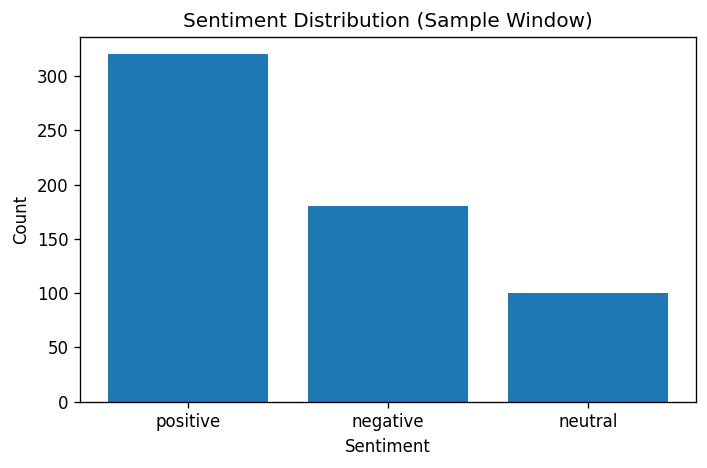

Saved: /content/sentiment_distribution.png


In [ ]:
#Sentiment Distribution (Bar Chart)
# chart_08_sentiment_distribution.py
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example sentiment counts (replace with your counts)
sentiment_counts = {'positive': 320, 'negative': 180, 'neutral': 100}
sentiment_df = pd.DataFrame(list(sentiment_counts.items()), columns=['sentiment','count'])

out = "/content/sentiment_distribution.png"

plt.figure(figsize=(6,4))
plt.bar(sentiment_df['sentiment'], sentiment_df['count'])
plt.title('Sentiment Distribution (Sample Window)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


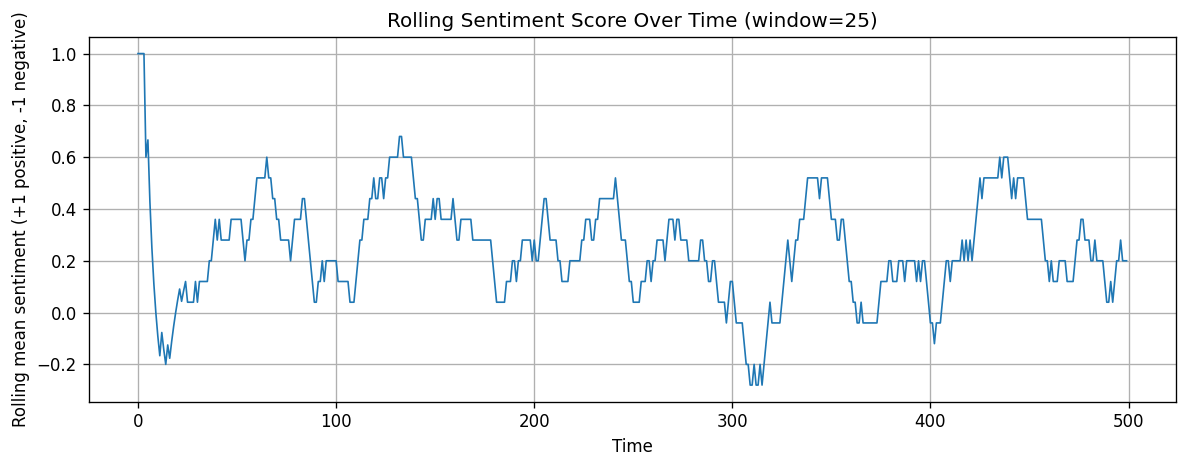

Saved: /content/rolling_sentiment.png


In [ ]:
#Rolling Sentiment Score Over Time (line)
# chart_09_rolling_sentiment.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120

# Example rolling sentiment: +1 (positive) / -1 (negative) sampled over time
time_points = np.arange(0, 500)
raw_sent = np.random.choice([1, -1], size=len(time_points), p=[0.62, 0.38])
rolling_window = 25
rolling = pd.Series(raw_sent).rolling(window=rolling_window, min_periods=1).mean()

out = "/content/rolling_sentiment.png"

plt.figure(figsize=(10,4))
plt.plot(time_points, rolling, linewidth=1)
plt.title(f'Rolling Sentiment Score Over Time (window={rolling_window})')
plt.xlabel('Time')
plt.ylabel('Rolling mean sentiment (+1 positive, -1 negative)')
plt.grid(True)
plt.tight_layout()
plt.savefig(out)
plt.show()
print("Saved:", out)


/tmp/ipython-input-3888786356.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')
/tmp/ipython-input-3888786356.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


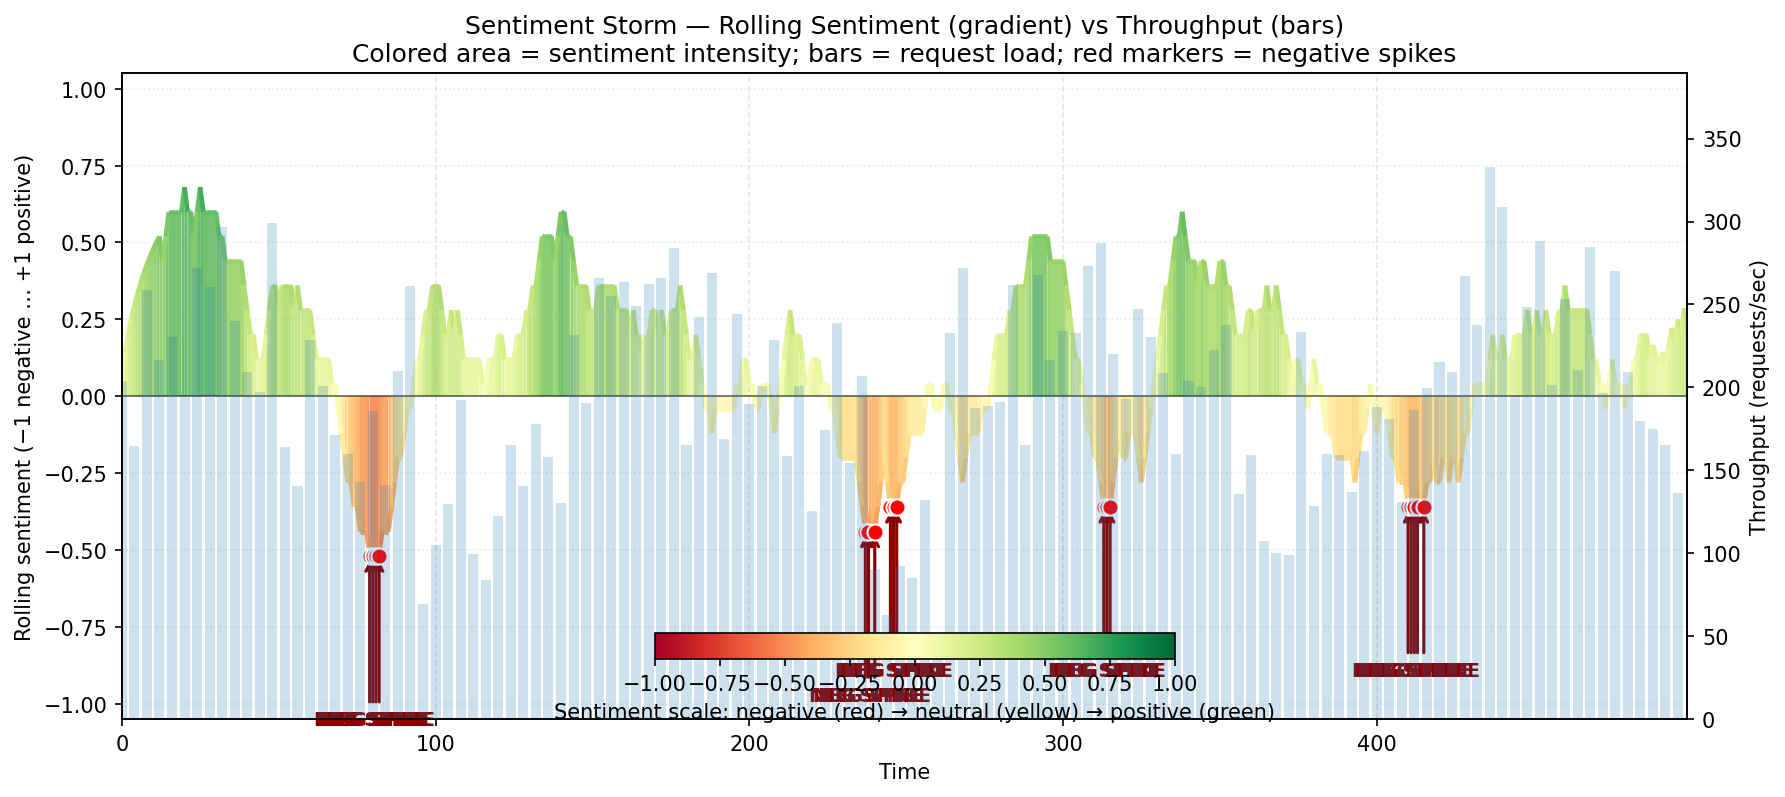

Saved chart to: /content/powerful_sentiment_chart.png


In [ ]:
# powerful_sentiment_chart.py
# Single powerful, colorful chart: gradient-filled rolling sentiment + throughput bars + anomaly annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib import cm
from matplotlib.colors import Normalize
import math

plt.rcParams['figure.dpi'] = 150

# -------------------------
# Synthetic example data (replace with your real metrics)
# -------------------------
np.random.seed(42)
T = 500
time = np.arange(T)

# raw sentiment: +1 pos, -1 neg; simulate bursts
raw = np.random.choice([1, -1], size=T, p=[0.62, 0.38])
# introduce a few strong negative bursts (anomalies)
for center in [80, 240, 320, 420]:
    raw[max(0, center-5):min(T, center+5)] = np.random.choice([-1], size= min(10, T-center+5))

# rolling sentiment (smooth)
window = 25
rolling = pd.Series(raw).rolling(window=window, min_periods=1, center=True).mean().values

# throughput (requests/sec) — context metric, simulate variation
minutes = np.linspace(0, T/10, T)  # scale to minutes
throughput = np.clip(190 + 60 * np.sin(minutes / 2.2) + 40 * np.random.randn(T), a_min=20, a_max=None)

# identify negative anomaly spikes (rolling low points)
anomaly_threshold = -0.3
anomalies_idx = np.where(rolling < anomaly_threshold)[0]
# keep only prominent local minima
prominent = []
for i in anomalies_idx:
    window_idx = rolling[max(0,i-3):min(T,i+4)]
    if rolling[i] <= window_idx.min():
        prominent.append(i)
anomalies = prominent

# -------------------------
# Plot: gradient area for rolling sentiment + throughput bars + annotations
# -------------------------
fig, ax1 = plt.subplots(figsize=(12,5))

# colormap: red (negative) -> yellow -> green (positive)
cmap = cm.get_cmap('RdYlGn')
norm = Normalize(vmin=-1.0, vmax=1.0)

# Build polygons for gradient fill: create vertices between consecutive points
verts = []
colors = []
for i in range(len(time)-1):
    x0, x1 = time[i], time[i+1]
    y0, y1 = rolling[i], rolling[i+1]
    verts.append([(x0, 0), (x0, y0), (x1, y1), (x1, 0)])
    # color by average of segment sentiment
    colors.append(cmap(norm( (y0 + y1) / 2.0 )))

poly = PolyCollection(verts, facecolors=colors, edgecolors='none', alpha=0.9)
ax1.add_collection(poly)

# colored line on top (matching gradient)
points = np.array([time, rolling]).T.reshape(-1,1,2)
from matplotlib.collections import LineCollection
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap='RdYlGn', norm=norm, linewidths=2.2)
lc.set_array(rolling[:-1])
ax1.add_collection(lc)

# zero horizontal line
ax1.axhline(0, color='black', linewidth=0.8, alpha=0.6)

# axis labels for sentiment
ax1.set_xlabel("Time")
ax1.set_ylabel("Rolling sentiment (−1 negative … +1 positive)")
ax1.set_ylim(-1.05, 1.05)
ax1.set_xlim(time.min(), time.max())

# Add throughput bars on secondary axis
ax2 = ax1.twinx()
bar_width = 0.8
# downsample throughput for readability (bars every n points)
step = max(1, len(time)//120)  # keep ~120 bars max
xs = time[::step]
ys = throughput[::step]
ax2.bar(xs, ys, width=bar_width*step, alpha=0.22, align='center', edgecolor='none')
ax2.set_ylabel("Throughput (requests/sec)")
ax2.set_ylim(0, max(throughput)*1.15)

# Annotations for anomalies
for idx in anomalies:
    x = time[idx]
    y = rolling[idx]
    ax1.scatter([x], [y], s=60, color='red', edgecolor='white', zorder=10)
    ax1.annotate("NEG SPIKE", xy=(x,y), xytext=(x, y-0.55),
                 arrowprops=dict(arrowstyle="->", color='darkred', lw=1.5),
                 horizontalalignment='center', color='darkred', fontsize=9, weight='bold')

# Add a colorbar legend for sentiment gradient
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax1,ax2], orientation='horizontal', fraction=0.045, pad=0.12)
cbar.set_label('Sentiment scale: negative (red) → neutral (yellow) → positive (green)')

# Title & grid
ax1.set_title("Sentiment Storm — Rolling Sentiment (gradient) vs Throughput (bars)\n"
              "Colored area = sentiment intensity; bars = request load; red markers = negative spikes")
ax1.grid(axis='x', linestyle='--', alpha=0.3)
ax1.grid(axis='y', linestyle=':', alpha=0.25)

plt.tight_layout()
out = "/content/powerful_sentiment_chart.png"
plt.savefig(out, dpi=200)
plt.show()

print("Saved chart to:", out)


TypeError: '<' not supported between instances of 'types.SimpleNamespace' and 'int'

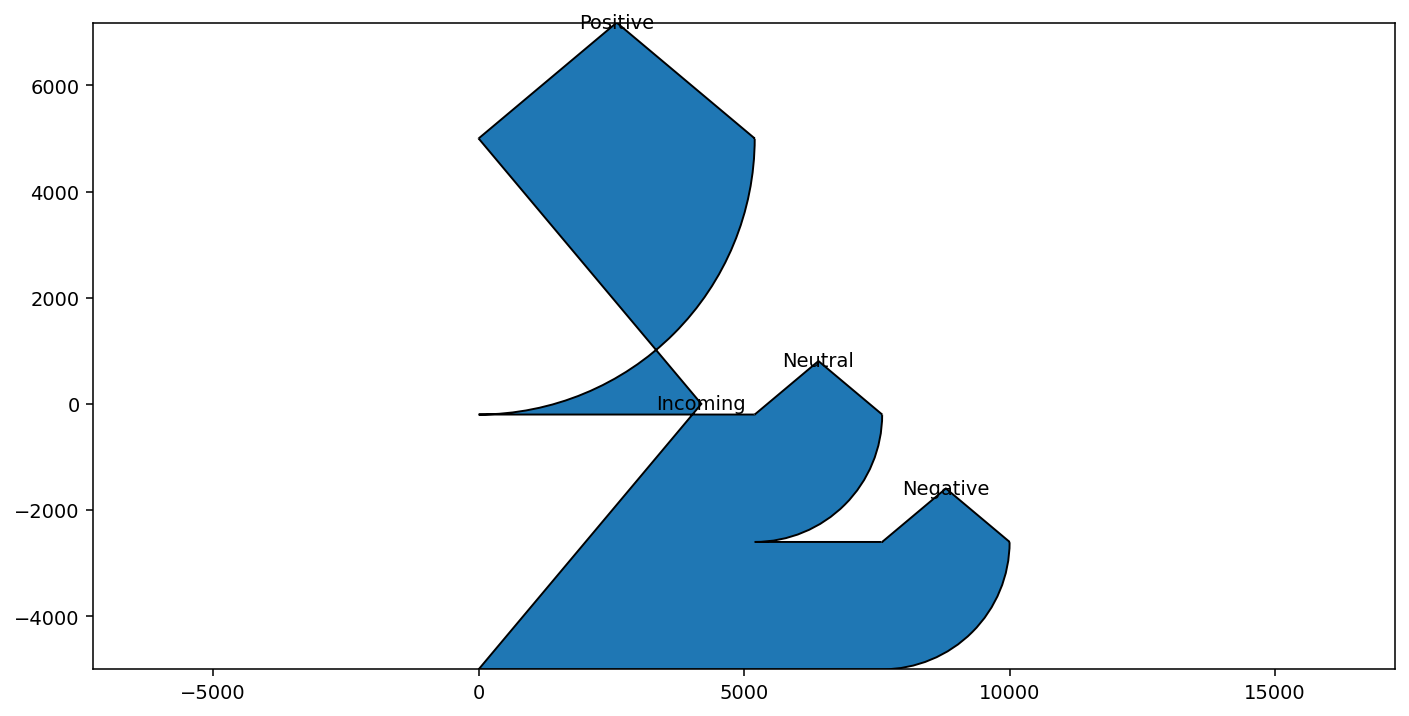

In [ ]:
# sankey_flow_chart.py
# Matplotlib Sankey: Incoming -> Sentiment -> Action
# Run this cell; replace synthetic counts with your real aggregated counts.

import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

plt.rcParams['figure.dpi'] = 140

# --------------------
# SYNTHETIC DATA (replace these with your real aggregated counts)
# --------------------
total_incoming = 10000
# sentiment counts must sum approximately to total_incoming (or be proportions)
pos = 5200
neu = 2400
neg = 2400

# fractions of each sentiment that cause an action/alert
pos_alert_frac = 0.01   # 1% of positives create follow-up
neu_alert_frac = 0.02   # 2% of neutrals
neg_alert_frac = 0.25   # 25% of negatives

pos_alerts = pos * pos_alert_frac
pos_no = pos - pos_alerts

neu_alerts = neu * neu_alert_frac
neu_no = neu - neu_alerts

neg_alerts = neg * neg_alert_frac
neg_no = neg - neg_alerts

# --------------------
# Build Sankey diagram with two stages:
# Stage A: total_incoming -> pos, neu, neg
# Stage B: pos -> pos_no + pos_alerts, etc. We draw second sankey anchored under each sentiment.
# --------------------
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
sankey = Sankey(ax=ax, unit=None, gap=0.6)

# Main split: incoming to sentiments
sankey.add(flows=[total_incoming, -pos, -neu, -neg],
           labels=['Incoming', 'Positive', 'Neutral', 'Negative'],
           orientations=[0, 1, 1, 1],
           trunklength=1.0,
           pathlengths=[0.25, 0.5, 0.5, 0.5])

diagrams = sankey.finish()
# Add sub-sankeys (for each sentiment) to show action vs no-action
# For clarity, we'll draw small Sankey off to the right for Positive, Neutral, Negative respectively.
x_offsets = [0.35, 0.6, 0.85]  # manual offsets to position the sub-sankeys
sent_vals = [(pos, pos_no, pos_alerts, 'Positive'),
             (neu, neu_no, neu_alerts, 'Neutral'),
             (neg, neg_no, neg_alerts, 'Negative')]

for i, (total, no_act, act, label) in enumerate(sent_vals):
    s = Sankey(ax=ax, unit=None, gap=0.4, scale=0.8)
    s.add(flows=[total, -no_act, -act],
          labels=[None, 'No action', 'Alert'],
          orientations=[0, 1, -1],
          prior=diagrams[0],             # attach to main
          connect=(i+1, 0),             # connect i-th outflow of main diagram to this sankey's input
          pathlengths=[0.25, 0.3, 0.3])
    try:
        s.finish()
    except Exception:
        # matplotlib Sankey can be finicky about connections; ignore failures to finish subdiagrams cleanly
        pass

ax.set_title("Sankey Flow: Incoming → Sentiment → Action (alerts/no-action)")
ax.axis('off')
plt.tight_layout()
plt.savefig("/content/sankey_flow.png", dpi=200)
plt.show()
print("Saved /content/sankey_flow.png")


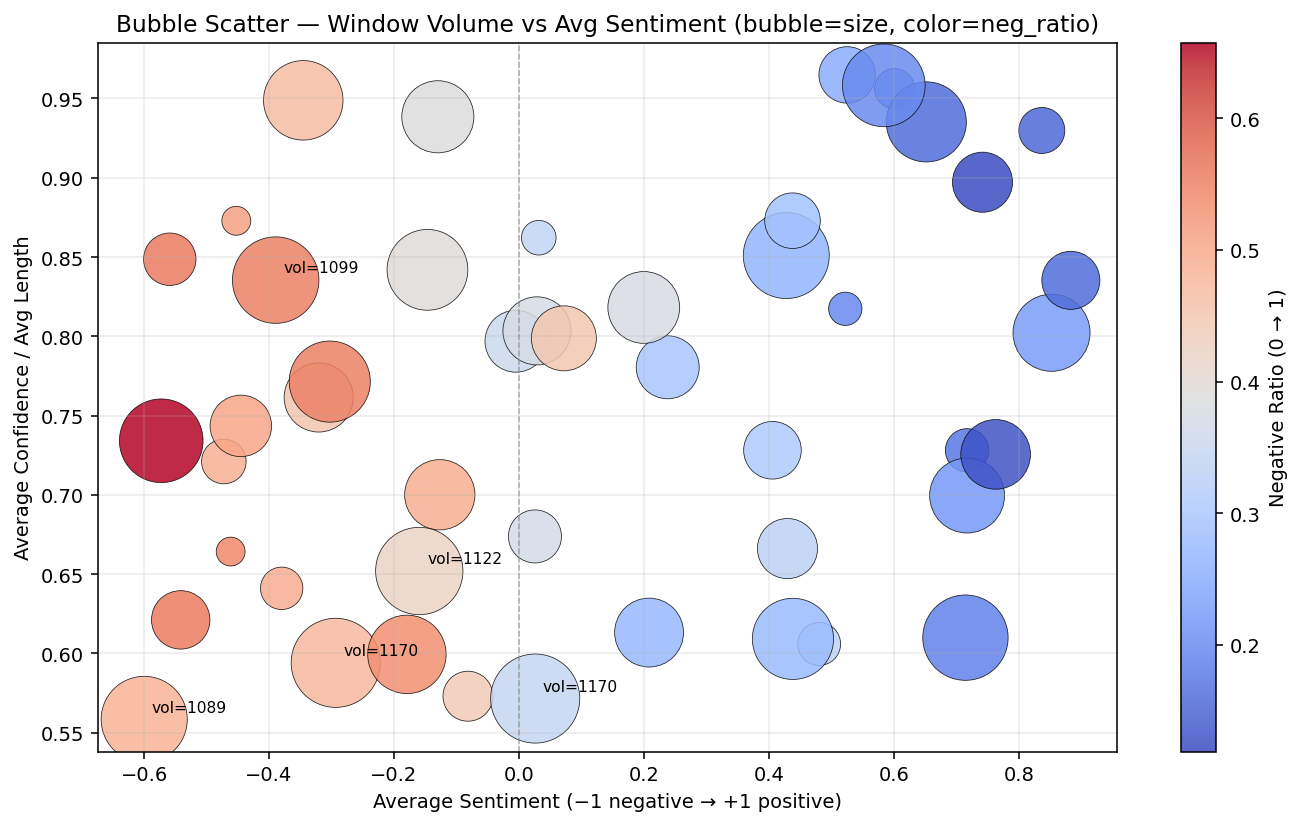

Saved /content/bubble_scatter.png


In [ ]:
#Bubble Scatter — Volume vs Avg Sentiment (per time-window)
# bubble_scatter_chart.py
# Bubble scatter: x = avg_sentiment, y = avg_confidence (or avg_length), size = volume, color = negative_ratio
# Replace synthetic arrays with your windowed aggregates.

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 140

# --------------------
# Synthetic windowed aggregates (replace with your data)
# Suppose we aggregate into 48 windows (e.g., 48 half-hours)
np.random.seed(1)
N = 48
avg_sentiment = np.random.uniform(-0.6, 0.9, size=N)   # -1..+1
avg_confidence = np.random.uniform(0.55, 0.98, size=N) # 0..1 (or avg message length)
volume = np.random.randint(50, 1200, size=N)           # messages per window
neg_ratio = np.clip(0.4 - avg_sentiment*0.3 + 0.05*np.random.randn(N), 0, 1)  # synthetic negativity fraction

# bubble sizes (scale volume for visibility)
sizes = (volume / volume.max()) * 2000 + 100

# color mapping: map neg_ratio to colormap (hotter = more negative)
cmap = plt.get_cmap('coolwarm')
colors = cmap(neg_ratio)  # array of RGBA

fig, ax = plt.subplots(figsize=(10,6))
sc = ax.scatter(avg_sentiment, avg_confidence, s=sizes, c=neg_ratio, cmap='coolwarm', alpha=0.85, edgecolor='k', linewidth=0.4)

# add labels for top-volume windows
top_idx = np.argsort(volume)[-5:]
for i in top_idx:
    ax.annotate(f"vol={volume[i]}", (avg_sentiment[i], avg_confidence[i]), textcoords="offset points", xytext=(4,4), fontsize=8)

ax.set_xlabel("Average Sentiment (−1 negative → +1 positive)")
ax.set_ylabel("Average Confidence / Avg Length")
ax.set_title("Bubble Scatter — Window Volume vs Avg Sentiment (bubble=size, color=neg_ratio)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Negative Ratio (0 → 1)")
# add grid and origin line for sentiment
ax.axvline(0, color='gray', linewidth=0.8, linestyle='--', alpha=0.6)
ax.grid(alpha=0.25)
plt.tight_layout()
plt.savefig("/content/bubble_scatter.png", dpi=200)
plt.show()
print("Saved /content/bubble_scatter.png")


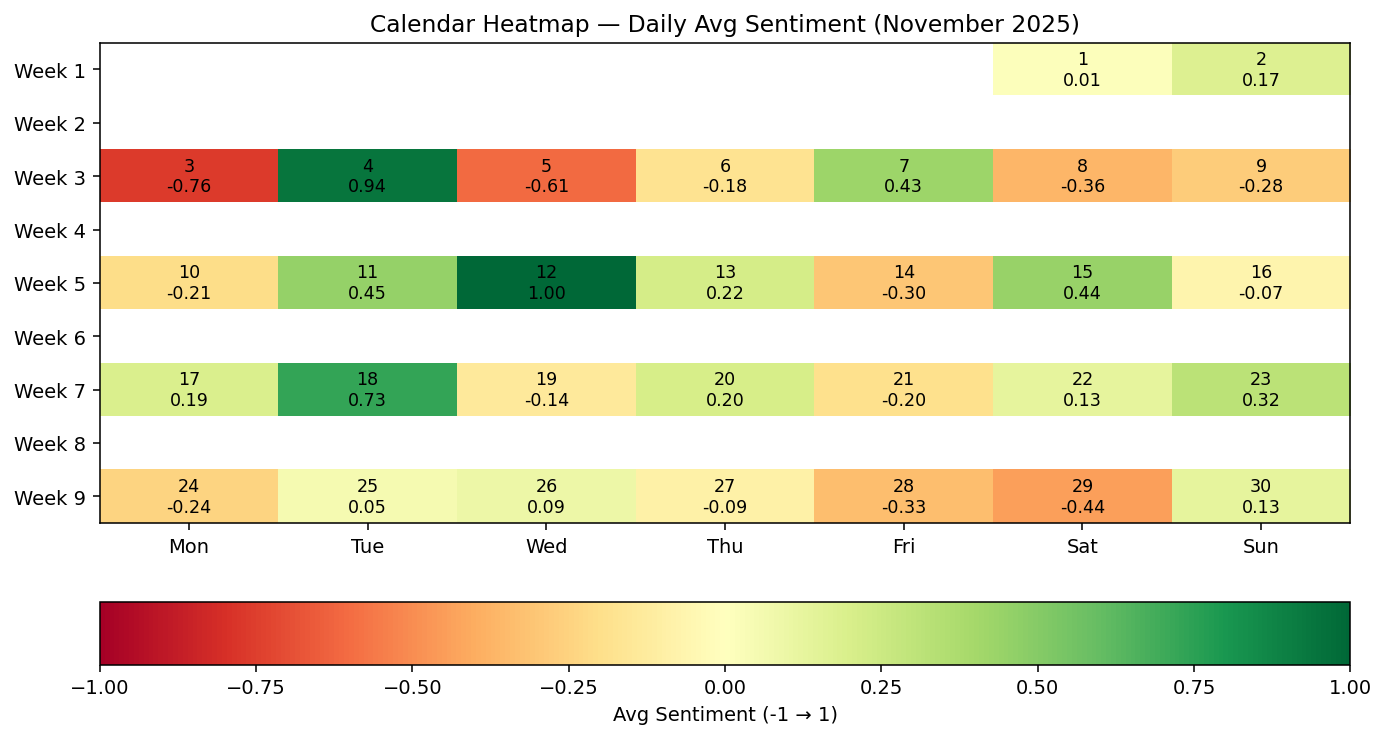

Saved: /content/calendar_heatmap_2025_11.png


In [ ]:
# Calendar Heatmap (matplotlib) — corrected and robust
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta

plt.rcParams['figure.dpi'] = 140

# --- Replace with your real daily averages (list or pd.Series indexed by date) ---
# Example: build synthetic daily sentiment for November 2025
year = 2025
month = 11
start = datetime(year, month, 1)
num_days = calendar.monthrange(year, month)[1]
dates = [start + timedelta(days=i) for i in range(num_days)]
np.random.seed(2)
daily_sentiments = np.clip(np.random.normal(0.2, 0.45, size=num_days), -1, 1)
# If you have a pandas Series: daily_series = pd.Series(your_values, index=pd.to_datetime(list_of_dates))
# --------------------------------------------

# Convert to dict for easy lookup by day
sent_by_day = {d.day: val for d, val in zip(dates, daily_sentiments)}

# Determine the first weekday (Mon=0 .. Sun=6)
first_weekday = start.weekday()
weeks = []
week = [np.nan]*7
day = 1

# Fill weeks list with rows of 7 entries (Mon..Sun), using NaN for blanks
while day <= num_days:
    weekday = (first_weekday + (day - 1)) % 7
    # put value in current week slot; if new week, append and reset accordingly
    if weekday == 0 and (day != 1):
        weeks.append(week)
        week = [np.nan]*7
    week[weekday] = sent_by_day[day]
    if weekday == 6:
        weeks.append(week)
        week = [np.nan]*7
    day += 1
# append last partial week if not empty
if any(not (x is np.nan) for x in week):
    weeks.append(week)

cal_arr = np.array(weeks, dtype=float)

# Plot
fig, ax = plt.subplots(figsize=(10, max(3, len(weeks)*0.6)))
cax = ax.imshow(cal_arr, aspect='auto', cmap='RdYlGn', vmin=-1, vmax=1)

# annotate each cell with day number and value when present
# Compute mapping day->(week_index, weekday_index)
day_idx = {}
d = 1
for wi in range(len(weeks)):
    for wd in range(7):
        if weeks[wi][wd] is not np.nan:
            day_idx[d] = (wi, wd)
            d += 1

# Now place day number and value
for day_num, (wi, wd) in day_idx.items():
    value = sent_by_day[day_num]
    text = f"{day_num}\n{value:.2f}"
    ax.text(wd, wi, text, ha='center', va='center', fontsize=9, color='black')

# Labels and ticks
ax.set_xticks(range(7))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_yticks(range(len(weeks)))
ax.set_yticklabels([f"Week {i+1}" for i in range(len(weeks))])
ax.set_title(f"Calendar Heatmap — Daily Avg Sentiment ({calendar.month_name[month]} {year})")
plt.colorbar(cax, orientation='horizontal', pad=0.12, label='Avg Sentiment (-1 → 1)')
plt.tight_layout()

png_path = f"/content/calendar_heatmap_{year}_{month:02d}.png"
plt.savefig(png_path, dpi=200)
plt.show()
print("Saved:", png_path)


In [ ]:
%%bash
cat > /content/drive/MyDrive/rt_nlp_sentiment_project/README.md <<'MD'
# Real-Time NLP Sentiment Analysis (Colab demo)

## Summary
This project implements an end-to-end real-time sentiment pipeline:
- Data: Sentiment140 + SST-2
- Models: TF-IDF+LR baseline, DistilBERT transformer
- API: FastAPI with single & batch inference
- Dashboard: Streamlit showing live feed, KPIs & alerts
- Explainability: SHAP token-level explanations
- Monitoring: latency metrics, /health endpoint
- Artifacts: saved models in Google Drive

## Run in Colab
Follow the notebook cells to install deps, mount Drive, prepare data, train models, and run the API + Streamlit (exposed via ngrok).

## Notes
- Colab sessions are ephemeral. Export models to Drive or Hugging Face for persistence.
- For production, run Docker image and use Redis/Kafka and a model server like TorchServe/Triton.

MD

echo "README saved to Drive."


README saved to Drive.


bash: line 1: /content/drive/MyDrive/rt_nlp_sentiment_project/README.md: No such file or directory
